In [29]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
from os import listdir
from os.path import isfile, join, isdir


Load data


In [96]:
import chardet
RELATIVE_DATA_PATH = './data'

# Load metadata
metadata = pd.read_csv(join(RELATIVE_DATA_PATH, 'metadata.csv'))

# Load data
countries = [f for f in listdir(RELATIVE_DATA_PATH) if isdir(join(RELATIVE_DATA_PATH, f))]

frames = []
for country in countries:
    print(f"Parsing {country}")
    pollutantsPath = join(RELATIVE_DATA_PATH, country)
    pollutants = [f for f in listdir(pollutantsPath) if isdir(join(pollutantsPath, f)) ]
    
    for pollutant in pollutants:
        pollutantPath = join(pollutantsPath, pollutant)
        dataCSVs = [f for f in listdir(pollutantPath)]
        
        for dataCSV in dataCSVs:
            dataCSVPath = join(pollutantPath, dataCSV)
            
            with open(dataCSVPath, 'rb') as f:
                info = chardet.detect(f.read())
                currentCSV = pd.read_csv(dataCSVPath, sep=',', encoding=info.get('encoding'))
                frames.append(currentCSV)
            
data = pd.concat(frames)

# Convert data columns
data.DatetimeBegin = pd.to_datetime(data.DatetimeBegin)
data.DatetimeEnd = pd.to_datetime(data.DatetimeEnd)

# Set index
data.set_index(['DatetimeBegin'], inplace = True)

# Sort by index (by DatetimeBegin)
data.sort_index(inplace=True)


Parsing CH


/Users/so/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Data


In [97]:
data.head(5)


,AirPollutant,AirPollutantCode,AirQualityNetwork,AirQualityStation,AirQualityStationEoICode,AveragingTime,Concentration,Countrycode,DatetimeEnd,Namespace,Sample,SamplingPoint,SamplingProcess,UnitOfMeasurement,Unnamed: 0,Validity,Verification
DatetimeBegin,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+01:00,CO,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,NET-CH003A,STA-CH0002R,CH0002R,hour,0.329,CH,2013-01-01 01:00:00+01:00,CH.BAFU.AQ,SPO_F-CH0002R_00010_100_100,SPO-CH0002R_00010_100,SPP-CH_A_5150551505,mg/m3,NaN,1.0,1.0
2013-01-01 00:00:00+01:00,PM10,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,NET-CH003A,STA-CH0002R,CH0002R,day,7.400,CH,2013-01-02 00:00:00+01:00,CH.BAFU.AQ,SPO_F-CH0002R_00005_100_100,SPO-CH0002R_00005_100,SPP-CH_A_5150551505,µg/m3,NaN,1.0,1.0
2013-01-01 00:00:00+01:00,SO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,NET-CH003A,STA-CH0005A,CH0005A,hour,15.300,CH,2013-01-01 01:00:00+01:00,CH.BAFU.AQ,SPO_F-CH0005A_00001_502_502,SPO-CH0005A_00001_502,SPP-CH_A_UV-FL_thermo43i-TLE,µg/m3,NaN,1.0,1.0
2013-01-01 00:00:00+01:00,NO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,NET-CH003A,STA-CH0002R,CH0002R,hour,13.000,CH,2013-01-01 01:00:00+01:00,CH.BAFU.AQ,SPO_F-CH0002R_00008_100_102,SPO-CH0002R_00008_100,SPP-CH_A_5150551505,µg/m3,NaN,1.0,1.0
2013-01-01 00:00:00+01:00,CO,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,NET-CH003A,STA-CH0002R,CH0002R,hour,0.329,CH,2013-01-01 01:00:00+01:00,CH.BAFU.AQ,SPO_F-CH0002R_00010_100_100,SPO-CH0002R_00010_100,SPP-CH_A_NDIR_horibaAPMA360,mg/m3,NaN,1.0,1.0


Metadata


In [98]:
metadata.sample(5)


,Countrycode,Namespace,AirQualityNetwork,AirQualityStation,AirQualityStationNatCode,AirQualityStationEoICode,AirQualityStationArea,SamplingPoint,SamplingProcess,Sample,...,MeasurementEquipment,MeasurementType,MeasurementMethod,AirPollutantCode,AirPollutant,AirQualityStationType,Projection,Longitude,Latitude,Altitude
18259,ES,ES.BDCA.AQD,NET_ES209A,STA_ES1117A,43171001,ES1117A,suburban,SP_43171001_19_M,SPP_43171001_19_M.2,SAM_43171001_19_M,...,NaN,active,NaN,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,Pb in PM10,background,EPSG:4979,1.151824,41.112091,41.0
17716,ES,ES.BDCA.AQD,NET_ES208A,STA_ES0373A,24057003,ES0373A,suburban,SP_24057003_10_47,SPP_24057003_10_47.1,SAM_24057003_10_47,...,http://dd.eionet.europa.eu/vocabulary/aq/measu...,automatic,http://dd.eionet.europa.eu/vocabulary/aq/measu...,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,PM10,industrial,EPSG:4979,-6.520833,42.625556,720.0
7309,CH,CH.BAFU.AQ,NET-CH003A,STA-CH0011A,tiLUG,CH0011A,urban,SPO-CH0011A_00005_100,SPP-CH_A_2977_2977,SPO_F-CH0011A_00005_100_103,...,http://dd.eionet.europa.eu/vocabulary/aq/measu...,automatic,http://dd.eionet.europa.eu/vocabulary/aq/measu...,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,PM10,background,EPSG:4979,NaN,NaN,280.0
52049,SE,SE.NV.AQ,NET-SE0009C,STA-SE0102A,10772,SE0102A,urban,SPO-SE0102A_00008_100,SPP-SE0102A_00008_100_101,NaN,...,http://dd.eionet.europa.eu/vocabulary/aq/measu...,automatic,http://dd.eionet.europa.eu/vocabulary/aq/measu...,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,NO2,background,EPSG:4979,15.629400,60.608299,130.0
1281,AT,AT.0008.20.AQ,NET-AT001A,STA-AT55032,055032,AT55032,suburban,SPO-AT55032_00007_100,SPP-AT_N_gravi_00714,SPO_F-AT55032_00007_100_100,...,NaN,active,NaN,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,O3,background,EPSG:4979,13.806926,47.125849,1025.0


In [99]:
# Print shape of data
data.shape


(140043, 17)

# Pollutants: 

We can see the following charts stating how different pollutants level affect our health.

![Pollutants levels description](img/pollutantsLevelsDescription.jpg)
![Pollutants levels ](img/pollutantsLevels.jpg)

At first, we are going to focus only on Switzerland and explore different pollutants variation throughout time (both short term and long term) 



In [101]:
# Get switzerland's data
switzerland = data[ data.Countrycode == 'CH']


###  Focusing on NO2


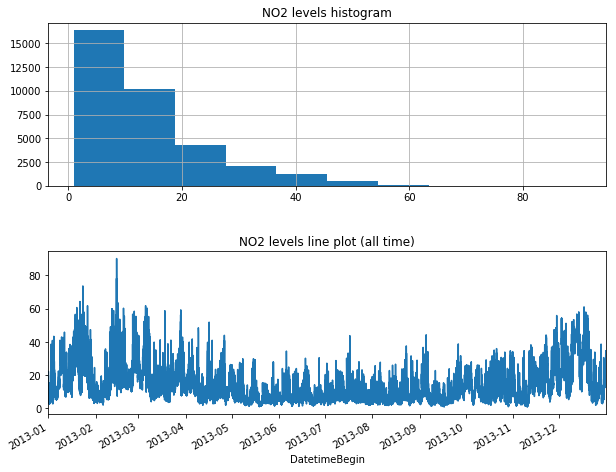

In [211]:
no2 = switzerland[ switzerland.AirPollutant == 'NO2' ]
fig, axes = plt.subplots(nrows=2, figsize=(10, 8))
plt.subplots_adjust(hspace = 0.4)

no2.Concentration.hist(ax=axes[0])
axes[0].title.set_text("NO2 levels histogram")

no2.Concentration.plot(ax=axes[1])
axes[1].title.set_text("NO2 levels line plot (all time)")



### Going more in depth

We are trying to see correlations between the time of day.

During the night we can observe the lowest amount of NO2, oppositly the levels of NO2 seem to peak at evening. Also days seems to follow the same pattern.


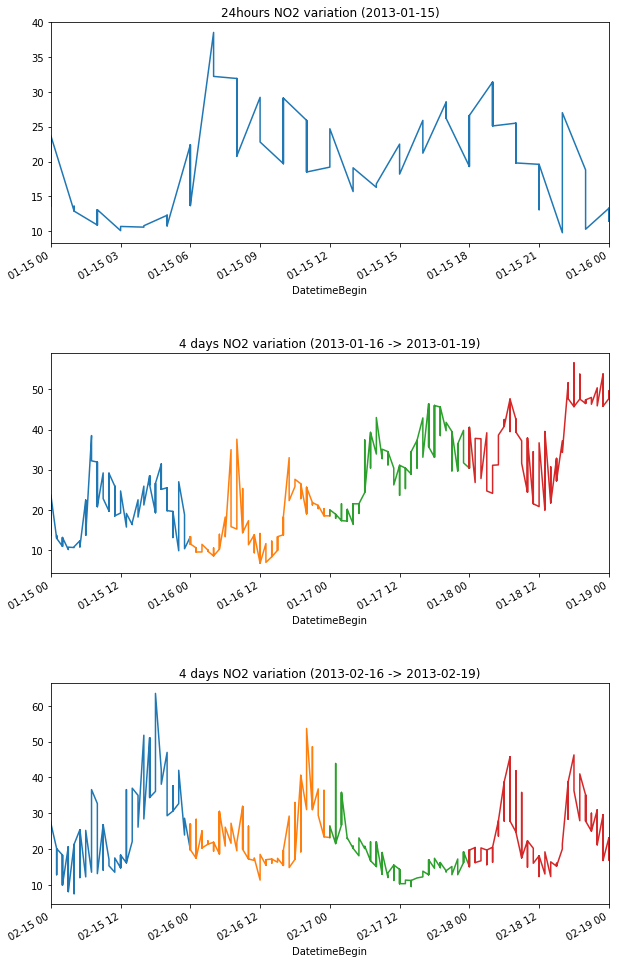

In [249]:
fig, axes = plt.subplots(nrows=3, figsize=(10, 18))
plt.subplots_adjust(hspace = 0.5)

no2.loc['2013-01-15 00:00:00+0100':'2013-01-16 00:00:00+0100'].Concentration.plot(ax=axes[0])
axes[0].title.set_text("24hours NO2 variation (2013-01-15)")

no2.loc['2013-01-15 00:00:00+0100':'2013-01-16 00:00:00+0100'].Concentration.plot(ax=axes[1])
no2.loc['2013-01-16 00:00:00+0100':'2013-01-17 00:00:00+0100'].Concentration.plot(ax=axes[1])
no2.loc['2013-01-17 00:00:00+0100':'2013-01-18 00:00:00+0100'].Concentration.plot(ax=axes[1])
no2.loc['2013-01-18 00:00:00+0100':'2013-01-19 00:00:00+0100'].Concentration.plot(ax=axes[1])
axes[1].title.set_text("4 days NO2 variation (2013-01-16 -> 2013-01-19)")

no2.loc['2013-02-15 00:00:00+0100':'2013-02-16 00:00:00+0100'].Concentration.plot(ax=axes[2])
no2.loc['2013-02-16 00:00:00+0100':'2013-02-17 00:00:00+0100'].Concentration.plot(ax=axes[2])
no2.loc['2013-02-17 00:00:00+0100':'2013-02-18 00:00:00+0100'].Concentration.plot(ax=axes[2])
no2.loc['2013-02-18 00:00:00+0100':'2013-02-19 00:00:00+0100'].Concentration.plot(ax=axes[2])
axes[2].title.set_text("4 days NO2 variation (2013-02-16 -> 2013-02-19)")

    
